# Indic to English


In [ ]:
!pip install tensorflow==2.14.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!git clone https://github.com/AI4Bharat/IndicTrans2.git

In [ ]:
%%capture
%cd /content/IndicTrans2/huggingface_interface

In [ ]:
%%capture
!python3 -m pip install nltk sacremoses pandas regex mock transformers>=4.33.2 mosestokenizer
!python3 -c "import nltk; nltk.download('punkt')"
!python3 -m pip install bitsandbytes scipy accelerate datasets
!python3 -m pip install sentencepiece

!git clone https://github.com/VarunGumma/IndicTransTokenizer
%cd IndicTransTokenizer
!python3 -m pip install --editable ./
%cd ..

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ENCODER_LEN = 100
DECODER_LEN = 100
BATCH_SIZE = 32
BUFFER_SIZE = BATCH_SIZE*4

In [ ]:
import pandas as pd

# Define file paths
file_paths = {
    "Nepali": "/content/drive/MyDrive/dataset/nepali.csv",
    "Assamese": "/content/drive/MyDrive/dataset/assamese.csv",
    "Bodo": "/content/drive/MyDrive/dataset/bodo.csv",
    "Khasi": "/content/drive/MyDrive/dataset/khasi.csv",
    "Manipuri": "/content/drive/MyDrive/dataset/manipuri.csv",
    "Mizo": "/content/drive/MyDrive/dataset/mizo.csv"
}

# Process each file
for lang, file_path in file_paths.items():
    # Load the dataset
    df = pd.read_csv(file_path)

    # Check if there are at least 2 columns
    if df.shape[1] >= 2:
        # Swap column 1 and column 2
        df.iloc[:, [0, 1]] = df.iloc[:, [1, 0]]

        # Define new file path with the "rev" prefix
        new_file_path = f"/content/drive/MyDrive/dataset/rev{lang}.csv"

        # Save the modified DataFrame
        df.to_csv(new_file_path, index=False)

        print(f"Processed file: {file_path}, saved as: {new_file_path}")
    else:
        print(f"File {file_path} does not have at least 2 columns, skipped.")


Processed file: /content/drive/MyDrive/dataset/nepali.csv, saved as: /content/drive/MyDrive/dataset/revNepali.csv
Processed file: /content/drive/MyDrive/dataset/assamese.csv, saved as: /content/drive/MyDrive/dataset/revAssamese.csv
Processed file: /content/drive/MyDrive/dataset/bodo.csv, saved as: /content/drive/MyDrive/dataset/revBodo.csv
Processed file: /content/drive/MyDrive/dataset/khasi.csv, saved as: /content/drive/MyDrive/dataset/revKhasi.csv
Processed file: /content/drive/MyDrive/dataset/manipuri.csv, saved as: /content/drive/MyDrive/dataset/revManipuri.csv
Processed file: /content/drive/MyDrive/dataset/mizo.csv, saved as: /content/drive/MyDrive/dataset/revMizo.csv


In [ ]:
# Load each dataset
train_df_nepali = pd.read_csv("/content/drive/MyDrive/dataset/revNepali.csv")
train_df_assamese = pd.read_csv("/content/drive/MyDrive/dataset/revAssamese.csv")
train_df_bodo = pd.read_csv("/content/drive/MyDrive/dataset/revBodo.csv")
train_df_khasi = pd.read_csv("/content/drive/MyDrive/dataset/revKhasi.csv")
train_df_manipuri = pd.read_csv("/content/drive/MyDrive/dataset/revManipuri.csv")
train_df_mizo = pd.read_csv("/content/drive/MyDrive/dataset/revMizo.csv")



In [ ]:
train_df_assamese.drop_duplicates()

ENGLISH  \
0                                  মেলি থোৱা দীঘল চুলি।\n   
1       যিয়েই নহওঁক, যিসকলে এই কাৰ্য্য প্ৰাণপণে কৰা চে...   
2       ইয়োব ৩৮ :⁠ ৪ - ​ ৬ পদত উল্লেখ কৰা লিখনীৰ পৰা আ...   
3       এই সন্দৰ্ভত তেওঁ পীলাতক এইদৰে কৈছিল যে, “সত্যত...   
4       ক'ৰ'নাৰ বিভীষিকাৰ মাজতো গুৱাহাটী বিশ্ববিদ্যালয়...   
...                                                   ...   
141228                                 গতিকে ভগৱান কোন?\n   
141229                                     বৰ্ণনা কৰক ।\n   
141230  যীচুৱে তেওঁৰ শিষ্যসকলক পৰিচালিত কৰিবলৈ কেনেকৈ ...   
141231  দ্যা ৱৰ্ল্ড আলমেনাক নামৰ কিতাপখনে ধৰ্ম্ম অনুসৰ...   
141232  “ প্ৰসবোত্তৰ বাবে হোৱা মানসিক অৱসাদৰ ওপৰত জয়ী ...   

                                                 ASSAMESE  
0                                     Tie up long hair.\n  
1       Nevertheless, he gave this assurance: He that ...  
2       David wrote: Many things you yourself have don...  
3       To many people today, a martyr is more or less...  
4       After protests were conducted over the decisio...  
...                                                   ...  
141228                                     What is God?\n  
141229  Jehovahs feelings toward the haughty are clear.\n  
141230  As we approach the end of this system of thing...  
141231  What can be said about the religious situation...  
141232  I Won My Battle With Postpartum Depression. Aw...  

[141233 rows x 2 columns]

In [ ]:
train_df_bodo.drop_duplicates()


ENGLISH  \
0                    अन्नानै आंंनो दिनैनि अक्टखौ खिन्था\n   
1              बे ओनसोलनि फैगौ इभेन्टफोरखौ आंनो खोन्था।\n   
2                          दानि थाखाय टेक्सि बुक खालाम।\n   
3                     लेक्समार्कनि स्टक बेसेना बेसेबां?\n   
4                          अन्नानै गिबि फारिलाइखौ बोखार\n   
...                                                   ...   
116911  आरिमुगिरि दैखर बे दैखरा पारवा गामिनि राझारा खै...   
116912  गासै हादोरनिफ्रायनो आरिमुगिरिफोरा भेलकि दिन्थि...   
116913      आरुबिक्काद दैबाज्रुमा कुन्दला खाथियावबो दं।\n   
116914  आरुबिक्कारा बान्दो 16 किमि गोजान- बे मुहिनां ल...   
116915  आर्ज बैद्य फाहामसालिया, आर्ज बैद्य सालासनि सेर...   

                                                     BODO  
0                       please let me know today's date\n  
1                  show me upcoming events in this area\n  
2                                     book taxi for now\n  
3                   what is the stock price for lexmark\n  
4                          please remove the first list\n  
...                                                   ...  
116911  Artisan well This well is situated about 15 km...  
116912  Artists from across the country converge on th...  
116913       Aruvikkad waterfalls is also near Kundala.\n  
116914  Aruvikkara Dam 16 kms away -This picturesque p...  
116915  Arya Vaidya hospital, the main wing of Arya Va...  

[116914 rows x 2 columns]

In [ ]:
train_df_nepali.drop_duplicates()

ENGLISH  \
0       दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...   
1       तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...   
2       दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ...   
3       दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “...   
4       दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ...   
...                                                   ...   
151932  (ख) आयोजनाहरुको प्रकृति अनुरुप अनुगमन तथा मूल्...   
151933  (ग) उपयुक्तताअनुरुप आयोजनाहरुको निष्पक्ष अद्या...   
151934  (घ) क्रमिक रुपमा अनुगमन तथा मूल्याङ्कन तथ्याङ्...   
151935  ्(ँङ) केन्द्रीय अनुगमन तथा मूल्याङ्कन व्यवस्था...   
151936  (च) अनुगमन तथा मूल्याङ्कनको परिपाटीलाई कर्मचार...   

                                                   NEPALI  
0       It happened after the death of Saul, when Davi...  
1       it happened on the third day, that behold, a m...  
2       David said to him, "Where do you come from?" H...  
3       David said to him, "How did it go? Please tell...  
4       David said to the young man who told him, "How...  
...                                                   ...  
151932  (b) \tReporting will be regularised by develop...  
151933  (c) \tImpartial on-going, mid -term and impact...  
151934  (d) \tThe monitoring and evaluation data will ...  
151935  (e) \tAppropriate rules and regulations will b...  
151936  (f) \tThe concepts of management by result and...  

[150643 rows x 2 columns]

In [ ]:
train_df_mizo.drop_duplicates()

ENGLISH  \
0      isuan a thih hma khn a zirtrte tn eng nge a dlsak   
1      a twp thlenga chhel tr chuan jehova finna chu ...   
2      engtin nge mi dangte hmangaihna tak tak chuan ...   
3      infiamna thawmhnaw tamtk hi chu puan fn tha de...   
4      eng ti trin nge finna kan hmanna chuan min cht...   
...                                                  ...   
53480  ani chuan nangnin in tih hin ai chuan ka thil ...   
53481  tirhkohte a mi angin tirhkoh paula chuan antio...   
53482  entr nn in tina thu inang sawi ai chuan i nu l...   
53483  chuta tlangvlte chu kawtthlrah an tlu ang a ch...   
53484  pharaoan a va pan hnaih chuan israela thlahte ...   

                                                    MIZO  
0      before his death what did jesus pray in behalf...  
1      to endure to the end we must recognize that je...  
2      why does real love for others deter us from en...  
3      a lot of sportswear is made of very stretchabl...  
4          our exercising wisdom will move us to do what  
...                                                  ...  
53480  he said to them what have i now done in compar...  
53481  according to acts the apostle paul showed jews...  
53482  for example rather than saying essentially the...  
53483  therefore her young men shall fall in her stre...  
53484  when pharaoh drew near the people of israel li...  

[52849 rows x 2 columns]

In [ ]:
train_df_khasi.drop_duplicates()

ENGLISH  \
0      shu shim nuksa a ki jingput jingtem ki bym don...   
1      nga lah ban sngewsarong a ka jingshakri jong n...   
2      hynrei ka riewkynthei kaba im ha ki jingsngewb...   
3      bad to pdiang a ka jingpynim kum ka jingada kh...   
4      mynta to ngin apeit a ki bynta kiba phi la tho...   
...                                                  ...   
25995  u shna saw tylli ki kyrwoh ksiar bad u pyndait...   
25996  ki hyniew ki angel kiba la don a ki hyniew tyl...   
25997  katba u isaak u dang akren ha u iso ka rebekka...   
25998  ngi la nang leit sha khmat sha ka lieng bad ng...   
25999  bad kane ka dei ka khubor kito kiba bymman kin...   

                                                   KHASI  
0      and even things without life giving sound whet...  
1      i have therefore whereof i may glory through j...  
2      but she that liveth in pleasure is dead while ...  
3      and take the helmet of salvation and the sword...  
4      now concerning the things whereof ye wrote unt...  
...                                                  ...  
25995  and he cast for it four rings of gold and put ...  
25996  and the seven angels came out of the temple ha...  
25997  and rebekah heard when isaac spake to esau his...  
25998  and we went before to ship and sailed unto ass...  
25999  behold his soul which is lifted up is not upri...  

[25982 rows x 2 columns]

In [ ]:
train_df_manipuri.drop_duplicates()

ENGLISH  \
0         একাকী হটি এলিসন হস্তমৈথুন Give Me আবেগ 12:00\n   
1      ওল পোৎ পিবা থবক থিবা বিলস শকখঙচেশিং সোশ্যাল সি...   
2      প্রয়াত নৃত্যশিল্পী অমলাশঙ্কর, মুখ্যমন্ত্রীর শ...   
3                         তেরি হা পাপদি দা মৈ ক্রেতা আ\n   
4       অদুবু মসিনা ঐখোয় য়ারে পেল্লে হায়বা য়াদ্রি।\n   
...                                                  ...   
60225  তেক্সশিং অমসুং লেবিসশিং রিফন্দ তৌদ্রিবা অমসুং ...   
60226          3. n য়ামদ্রবদা মী অনী খূৎ থাদুনা খৎনবা\n   
60227  অওনবশিংনা পুরকপা কান্নবশিং য়েংলবা মতুংদা হায়...   
60228           মরনা তেরী গলী মেঁ - জীনা তেরী গলী মেঁ।\n   
60229                on: জুলাই ০২, ২০২০ In: জন্মমৃত্যু\n   

                                                MANIPURI  
0            Alison Masturbate Give Me Emotions 12: 00\n  
1      Social Security, Social Security, and Social S...  
2      Late Nrityashilpi Amalashankar, Chief Minister...  
3              Teri Ha Papdi has a fire cracker in it.\n  
4                      But that doesn't mean we can't.\n  
...                                                  ...  
60225  Taxes and levies not refundable and duties, ce...  
60226                           b. at least two people\n  
60227  These rankings are made after evaluating the b...  
60228      Mera teri gali mein - Jeena teri gali mein.\n  
60229          On: July 30, 2018 In: भारतीय भारतीय में\n  

[60230 rows x 2 columns]

In [ ]:

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_nepali['ENGLISH'] = train_df_nepali['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'बड़ो' column
train_df_nepali['NEPALI'] = train_df_nepali['NEPALI'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_nepali['ENGLISH'] = train_df_nepali['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'बड़ो' column
train_df_nepali['NEPALI'] = train_df_nepali['NEPALI'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_nepali['ENGLISH'] = train_df_nepali['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'बड़ो' column
train_df_nepali['NEPALI'] = train_df_nepali['NEPALI'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_nepali.replace('', np.nan, inplace=True)
train_df_nepali.dropna(subset=['NEPALI','ENGLISH'], inplace=True)

# Save the cleaned Nepali data to a new CSV file
train_df_nepali.to_csv('nepali.csv', columns=['NEPALI','ENGLISH'], index=False)

In [ ]:
def clean_manipuri_text(text):
    # Replace characters not in the Manipuri script with a space
    cleaned_text = re.sub(r'[^\u0980-\u09FF\s]', ' ', str(text).lower()) if pd.notnull(text) else ''
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text.strip())
    return cleaned_text
# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_manipuri['ENGLISH'] = train_df_manipuri['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_manipuri['ENGLISH'] = train_df_manipuri['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_manipuri['ENGLISH'] = train_df_manipuri['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Apply the cleaning function to the 'MANIPURI' column
train_df_manipuri['MANIPURI'] = train_df_manipuri['MANIPURI'].apply(clean_manipuri_text)

# Remove punctuation for the 'MANIPURI' column
train_df_manipuri['MANIPURI'] = train_df_manipuri['MANIPURI'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove rows with empty values
train_df_manipuri.replace('', np.nan, inplace=True)
train_df_manipuri.dropna(subset=['MANIPURI','ENGLISH'], inplace=True)

# Save the cleaned Manipuri data to a new CSV file
train_df_manipuri.to_csv('manipuri.csv', columns=['MANIPURI','ENGLISH'], index=False)

# Display the cleaned DataFrame
print(train_df_manipuri[['MANIPURI','ENGLISH']])

                                                MANIPURI  \
99                          আপবায়া আমিবায়িতা আপবায়িতা   
718                                       লোগাইন কান্দিন   
4332                                        প্রশ্ন প্রভু   
13157                 প্রশ্ন প্রশ্ন প্রশ্ন প্রশ্ন প্রশ্ন   
14160                                    আপনাবাক আমি মিন   
16630                                      কুনুকুন মাকুন   
20583  আবাদিয় আজন্য আজনিয় আজন্য আবাগত সন্বাদ না দিয...   
22441                            প্রশ্ন আপনি মর্ত শ্রেয়   
23317          আরুক্তা আরুক্তা আরুক্তা আবিন্যায় আসুজন্য   
25258                                           পাম্লোনা   
25563                  আপনুক্ত আপনুয়াগী আক্দক্শ আক্দক্শ   
25768                                    সুন্দ্রী প্রীনা   
26238                                   কুন্তুমিক মোটুসি   
27833  জুয়া প্রশ্ন্ত্র জুয় প্রশ্ন্ত্র প্রশ্ন জুয়া ...   
31179                                             প্রশ্ন   
34511                                   

In [ ]:
import re
import string

import pandas as pd
import numpy as np

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_assamese['ENGLISH'] = train_df_assamese['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_assamese['ENGLISH'] = train_df_assamese['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_assamese['ENGLISH'] = train_df_assamese['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ASSAMESE' column
train_df_assamese['ASSAMESE'] = train_df_assamese['ASSAMESE'].apply(lambda x: re.sub(r'[^a-zA-Z\u0980-\u09FF\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ASSAMESE' column
train_df_assamese['ASSAMESE'] = train_df_assamese['ASSAMESE'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ASSAMESE' column
train_df_assamese['ASSAMESE'] = train_df_assamese['ASSAMESE'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_assamese.replace('', np.nan, inplace=True)
train_df_assamese.dropna(subset=['ASSAMESE','ENGLISH'], inplace=True)

# Save the cleaned Assamese data to a new CSV file
train_df_assamese.to_csv('assamese.csv', columns=['ASSAMESE','ENGLISH'], index=False)

# Display the cleaned DataFrame
print(train_df_assamese[['ASSAMESE','ENGLISH']])


                                                 ASSAMESE  \
26                                            failed read   
42      firefox and the firefox logos are trademarks o...   
52                           choose a vpn connection type   
56         click on a service to add it to brandshortname   
72      the safety of your data on s could not be guar...   
...                                                   ...   
141189                                connection settings   
141190  citizens not only register grievances at the p...   
141197                                  older than s days   
141199         please enter the pin mentioned on device s   
141218         enter a text value for the s search option   

                                  ENGLISH  
26                          readselftests  
42                firefox firefox mozilla  
52                                    vpn  
56                         brandshortname  
72                                 s sslv  
...

In [ ]:


# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_khasi['ENGLISH'] = train_df_khasi['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'KHASI_DEVA' column
train_df_khasi['KHASI'] = train_df_khasi['KHASI'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_khasi['ENGLISH'] = train_df_khasi['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'KHASI' column
train_df_khasi['KHASI'] = train_df_khasi['KHASI'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_khasi['ENGLISH'] = train_df_khasi['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'KHASI' column
train_df_khasi['KHASI'] = train_df_khasi['KHASI'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_khasi.replace('', np.nan, inplace=True)
train_df_khasi.dropna(subset=[ 'KHASI','ENGLISH'], inplace=True)

# Save the cleaned Khasi data to a new CSV file
train_df_khasi.to_csv('khasi.csv', columns=['KHASI','ENGLISH'], index=False)

In [ ]:


# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_mizo['ENGLISH'] = train_df_mizo['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'MIZO_DEVA' column
train_df_mizo['MIZO'] = train_df_mizo['MIZO'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_mizo['ENGLISH'] = train_df_mizo['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'MIZO' column
train_df_mizo['MIZO'] = train_df_mizo['MIZO'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_mizo['ENGLISH'] = train_df_mizo['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'MIZO' column
train_df_mizo['MIZO'] = train_df_mizo['MIZO'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_mizo.replace('', np.nan, inplace=True)
train_df_mizo.dropna(subset=['MIZO','ENGLISH'], inplace=True)

# Save the cleaned Mizo data to a new CSV file
train_df_mizo.to_csv('mizo.csv', columns=['MIZO','ENGLISH'], index=False)


In [ ]:

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df_bodo['ENGLISH'] = train_df_bodo['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'BODO_DEVA' column
train_df_bodo['BODO'] = train_df_bodo['BODO'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df_bodo['ENGLISH'] = train_df_bodo['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'BODO' column
train_df_bodo['BODO'] = train_df_bodo['BODO'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df_bodo['ENGLISH'] = train_df_bodo['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'BODO' column
train_df_bodo['BODO'] = train_df_bodo['BODO'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df_bodo.replace('', np.nan, inplace=True)
train_df_bodo.dropna(subset=['BODO','ENGLISH'], inplace=True)

# Save the cleaned Bodo data to a new CSV file
train_df_bodo.to_csv('bodo.csv', columns=['BODO','ENGLISH'], index=False)


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Split the English to Bodo dataset into training, testing, and validation sets
train_data_bodo, temp_data_bodo = train_test_split(train_df_bodo, test_size=0.3, random_state=42)
val_data_bodo, test_data_bodo = train_test_split(temp_data_bodo, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Bodo
train_data_bodo.to_csv('trbodo.csv', columns=['BODO', 'ENGLISH'], index=False)
val_data_bodo.to_csv('vbodo.csv', columns=['BODO', 'ENGLISH'], index=False)
test_data_bodo.to_csv('tsbodo.csv', columns=['BODO', 'ENGLISH'], index=False)

# Split the English to Nepali dataset into training, testing, and validation sets
train_data_nepali, temp_data_nepali = train_test_split(train_df_nepali, test_size=0.3, random_state=42)
val_data_nepali, test_data_nepali = train_test_split(temp_data_nepali, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Nepali
train_data_nepali.to_csv('trnepali.csv', columns=['NEPALI', 'ENGLISH'], index=False)
val_data_nepali.to_csv('vnepali.csv', columns=['NEPALI', 'ENGLISH'], index=False)
test_data_nepali.to_csv('tenepali.csv', columns=['NEPALI', 'ENGLISH'], index=False)

# Split the English to Khasi dataset into training, testing, and validation sets
train_data_khasi, temp_data_khasi = train_test_split(train_df_khasi, test_size=0.3, random_state=42)
val_data_khasi, test_data_khasi = train_test_split(temp_data_khasi, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Khasi
train_data_khasi.to_csv('trkhasi.csv', columns=['KHASI', 'ENGLISH'], index=False)
val_data_khasi.to_csv('vkhasi.csv', columns=['KHASI', 'ENGLISH'], index=False)
test_data_khasi.to_csv('tkhasi.csv', columns=['KHASI', 'ENGLISH'], index=False)

# Split the English to Manipuri dataset into training, testing, and validation sets
train_data_manipuri, temp_data_manipuri = train_test_split(train_df_manipuri, test_size=0.3, random_state=42)
val_data_manipuri, test_data_manipuri = train_test_split(temp_data_manipuri, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Manipuri
train_data_manipuri.to_csv('trmanipuri.csv', columns=['MANIPURI', 'ENGLISH'], index=False)
val_data_manipuri.to_csv('vmanipuri.csv', columns=['MANIPURI', 'ENGLISH'], index=False)
test_data_manipuri.to_csv('tmanipuri.csv', columns=['MANIPURI', 'ENGLISH'], index=False)

# Split the English to Mizo dataset into training, testing, and validation sets
train_data_mizo, temp_data_mizo = train_test_split(train_df_mizo, test_size=0.3, random_state=42)
val_data_mizo, test_data_mizo = train_test_split(temp_data_mizo, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Mizo
train_data_mizo.to_csv('trmizo.csv', columns=['MIZO', 'ENGLISH'], index=False)
val_data_mizo.to_csv('vmizo.csv', columns=['MIZO', 'ENGLISH'], index=False)
test_data_mizo.to_csv('tmizo.csv', columns=['MIZO', 'ENGLISH'], index=False)

# Split the English to Assamese dataset into training, testing, and validation sets
train_data_assamese, temp_data_assamese = train_test_split(train_df_assamese, test_size=0.3, random_state=42)
val_data_assamese, test_data_assamese = train_test_split(temp_data_assamese, test_size=0.17, random_state=42)  # 0.17 * (0.7 / 0.3) = 0.15

# Save the training, validation, and testing data to separate CSV files for Assamese
train_data_assamese.to_csv('trassamese.csv', columns=['ASSAMESE', 'ENGLISH'], index=False)
val_data_assamese.to_csv('vassamese.csv', columns=['ASSAMESE', 'ENGLISH'], index=False)
test_data_assamese.to_csv('tassamese.csv', columns=['ASSAMESE', 'ENGLISH'], index=False)

In [ ]:
# Separate English to Bodo dataset
eng_b = train_df_bodo['ENGLISH']
brx = train_df_bodo['BODO']

# Separate English to Nepali dataset
eng_n = train_df_nepali['ENGLISH']
npi = train_df_nepali['NEPALI']

# Separate English to Khasi dataset
eng_khasi = train_df_khasi['ENGLISH']
khasi = train_df_khasi['KHASI']

# Separate English to Manipuri dataset
eng_manipuri = train_df_manipuri['ENGLISH']
manipuri = train_df_manipuri['MANIPURI']

# Separate English to Mizo dataset
eng_mizo = train_df_mizo['ENGLISH']
mizo = train_df_mizo['MIZO']

# Separate English to Assamese dataset
eng_assamese = train_df_assamese['ENGLISH']
assamese = train_df_assamese['ASSAMESE']


In [ ]:
eng_b = eng_b.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
brx = brx.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

# Use correct variable names in tokenizers
eng_b_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
brx_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_b_tokenizer.fit_on_texts(eng_b)
brx_tokenizer.fit_on_texts(brx)
inputs_bodo = eng_b_tokenizer.texts_to_sequences(eng_b)
targets_bodo = brx_tokenizer.texts_to_sequences(brx)

# Print tokenizers
print(eng_b_tokenizer)
print(brx_tokenizer)

In [ ]:
eng_n = eng_n.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
npi = npi.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

# Use correct variable names in tokenizers
eng_n_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
npi_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_n_tokenizer.fit_on_texts(eng_n)
npi_tokenizer.fit_on_texts(npi)
inputs_nepali = eng_b_tokenizer.texts_to_sequences(eng_n)
targets_nepali = brx_tokenizer.texts_to_sequences(npi)

# Print tokenizers
print(eng_n_tokenizer)
print(npi_tokenizer)



In [ ]:
# Preprocess Khasi dataset
eng_khasi = eng_khasi.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
khasi = khasi.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
eng_khasi_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
khasi_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_khasi_tokenizer.fit_on_texts(eng_khasi)
khasi_tokenizer.fit_on_texts(khasi)
inputs_khasi = eng_khasi_tokenizer.texts_to_sequences(eng_khasi)
targets_khasi = khasi_tokenizer.texts_to_sequences(khasi)

# Print tokenizers for Khasi
print(eng_khasi_tokenizer)
print(khasi_tokenizer)

# Preprocess Manipuri dataset
eng_manipuri = eng_manipuri.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
manipuri = manipuri.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
eng_manipuri_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
manipuri_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_manipuri_tokenizer.fit_on_texts(eng_manipuri)
manipuri_tokenizer.fit_on_texts(manipuri)
inputs_manipuri = eng_manipuri_tokenizer.texts_to_sequences(eng_manipuri)
targets_manipuri = manipuri_tokenizer.texts_to_sequences(manipuri)

# Print tokenizers for Manipuri
print(eng_manipuri_tokenizer)
print(manipuri_tokenizer)

# Preprocess Mizo dataset
eng_mizo = eng_mizo.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
mizo = mizo.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
eng_mizo_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
mizo_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_mizo_tokenizer.fit_on_texts(eng_mizo)
mizo_tokenizer.fit_on_texts(mizo)
inputs_mizo = eng_mizo_tokenizer.texts_to_sequences(eng_mizo)
targets_mizo = mizo_tokenizer.texts_to_sequences(mizo)

# Print tokenizers for Mizo
print(eng_mizo_tokenizer)
print(mizo_tokenizer)

# Preprocess Assamese dataset
eng_assamese = eng_assamese.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
assamese = assamese.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
eng_assamese_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
assamese_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
eng_assamese_tokenizer.fit_on_texts(eng_assamese)
assamese_tokenizer.fit_on_texts(assamese)
inputs_assamese = eng_assamese_tokenizer.texts_to_sequences(eng_assamese)
targets_assamese = assamese_tokenizer.texts_to_sequences(assamese)

# Print tokenizers for Assamese
print(eng_assamese_tokenizer)
print(assamese_tokenizer)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Collect all English texts from the different datasets
all_eng_texts = pd.concat([eng_b, eng_n, eng_khasi, eng_manipuri, eng_mizo, eng_assamese], ignore_index=True)

# Create a new tokenizer and fit it on the combined English texts
merged_eng_tokenizer = Tokenizer(filters=filters, oov_token=oov_token)
merged_eng_tokenizer.fit_on_texts(all_eng_texts)

# Print the merged English tokenizer
print(merged_eng_tokenizer)

# Optionally, save the tokenizer if needed
import pickle
with open('merged_eng_tokenizer.pkl', 'wb') as f:
    pickle.dump(merged_eng_tokenizer, f)


In [ ]:
DECODER_VOCAB = len(merged_eng_tokenizer.word_index) + 1
ENCODER_B_VOCAB = len(brx_tokenizer.word_index) + 1
print(ENCODER_B_VOCAB, DECODER_VOCAB)

6444 39992


In [ ]:
ENCODER_A_VOCAB = len(assamese_tokenizer.word_index) + 1
ENCODER_B_VOCAB = len(brx_tokenizer.word_index) + 1
ENCODER_N_VOCAB = len(npi_tokenizer.word_index) + 1
ENCODER_K_VOCAB = len(khasi_tokenizer.word_index) + 1
ENCODER_MI_VOCAB = len(mizo_tokenizer.word_index) + 1
ENCODER_MA_VOCAB = len(manipuri_tokenizer.word_index) + 1


In [ ]:

# Calculate max lengths among sequences
max_length_bodo_decoder = max(len(seq) for seq in inputs_bodo)
max_length_bodo_encoder = max(len(seq) for seq in targets_bodo)


# Calculate max lengths among sequences
max_length_nepali_decoder = max(len(seq) for seq in inputs_nepali)
max_length_nepali_encoder = max(len(seq) for seq in targets_nepali)


In [ ]:
# Calculate max lengths among sequences for all languages

# Bodo
max_length_bodo_decoder = max(len(seq) for seq in inputs_bodo)

# Nepali
max_length_nepali_decoder = max(len(seq) for seq in inputs_nepali)

# Khasi
max_length_khasi_decoder = max(len(seq) for seq in inputs_khasi)

# Manipuri
max_length_manipuri_decoder = max(len(seq) for seq in inputs_manipuri)

# Mizo
max_length_mizo_decoder = max(len(seq) for seq in inputs_mizo)

# Assamese
max_length_assamese_decoder = max(len(seq) for seq in inputs_assamese)

# Find the overall maximum length for the shared decoder
max_length_shared_decoder = max(
    max_length_bodo_decoder,
    max_length_nepali_decoder,
    max_length_khasi_decoder,
    max_length_manipuri_decoder,
    max_length_mizo_decoder,
    max_length_assamese_decoder
)
# Print maximum lengths for the shared encoder
print("Max length for shared decoder:", max_length_shared_decoder)

# Calculate max lengths among sequences for encoders
# Bodo
max_length_bodo_encoder = max(len(seq) for seq in targets_bodo)
# Nepali
max_length_nepali_encoder = max(len(seq) for seq in targets_nepali)
# Khasi
max_length_khasi_encoder = max(len(seq) for seq in targets_khasi)
# Manipuri
max_length_manipuri_encoder = max(len(seq) for seq in targets_manipuri)
# Mizo
max_length_mizo_encoder = max(len(seq) for seq in targets_mizo)
# Assamese
max_length_assamese_encoder = max(len(seq) for seq in targets_assamese)

# Find the overall maximum length for the encoders
max_length_encoder = max(
    max_length_bodo_encoder,
    max_length_nepali_encoder,
    max_length_khasi_encoder,
    max_length_manipuri_encoder,
    max_length_mizo_encoder,
    max_length_assamese_encoder
)

# Print maximum lengths for the encoders
print("Max length for all encoders:", max_length_encoder)


Max length for shared decoder: 1541
Max length for all encoders: 1062


In [ ]:
import tensorflow as tf

# Pad sequences to a common length for each language's encoder
def pad_and_convert(inputs, targets, max_length_encoder, max_length_decoder):
    inputs_padded = tf.keras.preprocessing.sequence.pad_sequences(
        inputs, maxlen=max_length_encoder, padding='post', truncating='post'
    )
    targets_padded = tf.keras.preprocessing.sequence.pad_sequences(
        targets, maxlen=max_length_decoder, padding='post', truncating='post'
    )
    inputs_tensor = tf.convert_to_tensor(inputs_padded)
    targets_tensor = tf.convert_to_tensor(targets_padded)
    return inputs_tensor, targets_tensor

# Example for Nepali
inputs_nepali, targets_shared = pad_and_convert(inputs_nepali, targets_nepali, max_length_nepali_encoder, max_length_shared_decoder)

# Similarly, pad and convert for Bodo
inputs_bodo, targets_shared = pad_and_convert(inputs_bodo, targets_bodo, max_length_bodo_encoder, max_length_shared_decoder)

# Similarly, pad and convert for Khasi
inputs_khasi, targets_shared = pad_and_convert(inputs_khasi, targets_khasi, max_length_khasi_encoder, max_length_shared_decoder)

# Similarly, pad and convert for Manipuri
inputs_manipuri, targets_shared = pad_and_convert(inputs_manipuri, targets_manipuri, max_length_manipuri_encoder, max_length_shared_decoder)

# Similarly, pad and convert for Mizo
inputs_mizo, targets_shared = pad_and_convert(inputs_mizo, targets_mizo, max_length_mizo_encoder, max_length_shared_decoder)

# Similarly, pad and convert for Assamese
inputs_assamese, targets_shared = pad_and_convert(inputs_assamese, targets_assamese, max_length_assamese_encoder, max_length_shared_decoder)


In [ ]:
print(inputs_bodo)
print(targets_bodo)
print(inputs_nepali)
print(targets_nepali)
print("Inputs Khasi:", inputs_khasi)
print("Targets Khasi:", targets_khasi)
print("Inputs Manipuri:", inputs_manipuri)
print("Targets Manipuri:", targets_manipuri)
print("Inputs Mizo:", inputs_mizo)
print("Targets Mizo:", targets_mizo)
print("Inputs Assamese:", inputs_assamese)
print("Targets Assamese:", targets_assamese)

tf.Tensor(
[[  2   4   3 ...   0   0   0]
 [  2   4   3 ...   0   0   0]
 [  2   4   3 ...   0   0   0]
 ...
 [  2  22  22 ...   0   0   0]
 [  2  22  22 ...   0   0   0]
 [  2 350   3 ...   0   0   0]], shape=(2254, 72), dtype=int32)
[[3, 53, 152, 10, 3101, 95, 4], [3, 39, 139, 8, 199, 1200, 381, 4], [3, 1201, 39, 139, 8, 247, 3102, 3103, 13, 414, 3104, 4], [3, 728, 84, 2, 453, 54, 993, 454, 1983, 4], [3, 212, 59, 994, 995, 267, 18, 1506, 8, 1506, 4], [3, 415, 84, 2, 830, 65, 5, 15, 248, 4], [3, 1202, 2, 1984, 4], [3, 39, 139, 8, 1203, 59, 3105, 3106, 416, 3107, 4], [3, 23, 26, 121, 37, 2, 237, 268, 122, 117, 7, 2, 330, 99, 11, 331, 5, 140, 13, 103, 53, 3108, 6, 65, 5, 86, 4], [3, 141, 238, 11, 3109, 3110, 62, 24, 289, 557, 354, 4], [3, 238, 289, 557, 354, 4], [3, 153, 40, 15, 239, 53, 3111, 9, 996, 4], [3, 629, 630, 59, 997, 5, 998, 8, 239, 53, 1204, 729, 4], [3, 999, 290, 176, 3112, 4], [3, 269, 3113, 831, 4], [3, 64, 1000, 158, 4], [3, 23, 26, 153, 40, 59, 1205, 558, 730, 1206, 311

In [ ]:
# Define constants for BUFFER_SIZE and BATCH_SIZE
BUFFER_SIZE = 10000  # Adjust as needed
BATCH_SIZE = 64      # Adjust as needed

# Pad sequences to the maximum length (ensure you have set these values appropriately)
max_length_bodo_encoder = max_length_bodo_encoder  # Define or calculate max length
max_length_shared_decoder = max_length_shared_decoder  # Define or calculate max length

def pad_sequences(sequences, max_length):
    return tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=max_length, padding='post', truncating='post'
    )

# Pad sequences
inputs_bodo_padded = pad_sequences(inputs_bodo, max_length_bodo_encoder)
targets_bodo_padded = pad_sequences(targets_bodo, max_length_shared_decoder)

inputs_nepali_padded = pad_sequences(inputs_nepali, max_length_nepali_encoder)
targets_nepali_padded = pad_sequences(targets_nepali, max_length_shared_decoder)

inputs_khasi_padded = pad_sequences(inputs_khasi, max_length_khasi_encoder)
targets_khasi_padded = pad_sequences(targets_khasi, max_length_shared_decoder)

inputs_manipuri_padded = pad_sequences(inputs_manipuri, max_length_manipuri_encoder)
targets_manipuri_padded = pad_sequences(targets_manipuri, max_length_shared_decoder)

inputs_mizo_padded = pad_sequences(inputs_mizo, max_length_mizo_encoder)
targets_mizo_padded = pad_sequences(targets_mizo, max_length_shared_decoder)

inputs_assamese_padded = pad_sequences(inputs_assamese, max_length_assamese_encoder)
targets_assamese_padded = pad_sequences(targets_assamese, max_length_shared_decoder)

# Create datasets
bodo_dataset = tf.data.Dataset.from_tensor_slices(
    (inputs_bodo_padded, targets_bodo_padded, np.ones(len(inputs_bodo_padded)))
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

nepali_dataset = tf.data.Dataset.from_tensor_slices(
    (inputs_nepali_padded, targets_nepali_padded, np.ones(len(inputs_nepali_padded)) * 2)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

khasi_dataset = tf.data.Dataset.from_tensor_slices(
    (inputs_khasi_padded, targets_khasi_padded, np.ones(len(inputs_khasi_padded)) * 3)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

manipuri_dataset = tf.data.Dataset.from_tensor_slices(
    (inputs_manipuri_padded, targets_manipuri_padded, np.ones(len(inputs_manipuri_padded)) * 4)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

mizo_dataset = tf.data.Dataset.from_tensor_slices(
    (inputs_mizo_padded, targets_mizo_padded, np.ones(len(inputs_mizo_padded)) * 5)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

assamese_dataset = tf.data.Dataset.from_tensor_slices(
    (inputs_assamese_padded, targets_assamese_padded, np.ones(len(inputs_assamese_padded)) * 6)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

[[3, 79, 16, 169, 49, 99, 69, 705, 8, 1447, 5, 16, 321, 4], [3, 7, 1348, 7, 2, 250, 38, 216, 2866, 11, 173, 262, 14, 342, 866, 151, 3249, 4], [3, 141, 171, 1248, 148, 13, 254, 9482, 66, 33, 8357, 8, 1002, 9483, 4], [3, 10, 600, 5, 14182, 14, 93, 5, 195, 14183, 1180, 4], [3, 55, 2960, 262, 17, 837, 66, 7, 51, 49, 4], [3, 27, 2, 2030, 5, 333, 45, 1164, 1061, 4], [3, 120, 148, 216, 4116, 4], [3, 12, 2335, 16, 768, 7475, 8, 16, 14184, 7, 3362, 8, 4], [3, 62, 9, 2268, 22, 768, 47, 8, 2, 2464, 548, 21, 17, 6230, 4], [3, 49, 51, 38, 259, 7, 51, 7, 1003, 254, 4], [3, 12, 268, 2, 973, 12, 58, 139, 2400, 6803, 14185, 4], [3, 68, 324, 1368, 7, 173, 552, 11, 53, 3760, 143, 1396, 4], [3, 15, 6, 27, 2, 53, 24, 31, 19, 41, 17, 1369, 2, 156, 4], [3, 81, 87, 38, 35, 1562, 5, 2, 866, 422, 1503, 33, 1151, 262, 4], [3, 99, 9, 463, 2, 1025, 5, 2, 1661, 4], [3, 42, 14, 2, 2551, 5, 37, 4], [3, 2, 116, 5, 4791, 4306, 29, 11199, 4], [3, 21, 588, 7, 476, 4], [3, 39, 21, 99, 32, 354, 7, 128, 4], [3, 37, 954, 49,

In [ ]:
def positional_encoding(position, d_model, lang_id):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model,
        lang_id
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        # Split the last dimension into (num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask, lang_id):
        batch_size = tf.shape(q)[0]

        # Apply language-specific embeddings
        lang_embedding = tf.one_hot(lang_id, depth=self.num_heads)
        q = tf.concat([q, lang_embedding], axis=-1)
        k = tf.concat([k, lang_embedding], axis=-1)
        v = tf.concat([v, lang_embedding], axis=-1)

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        # Define multi-head attention layers for each language
        self.mha = {
            'bodo': MultiHeadAttention(d_model, num_heads),
            'nepali': MultiHeadAttention(d_model, num_heads),
            'khasi': MultiHeadAttention(d_model, num_heads),
            'manipuri': MultiHeadAttention(d_model, num_heads),
            'mizo': MultiHeadAttention(d_model, num_heads),
            'assamese': MultiHeadAttention(d_model, num_heads)
        }

        # Define feed-forward networks for each language
        self.ffn = {
            'bodo': point_wise_feed_forward_network(d_model, dff),
            'nepali': point_wise_feed_forward_network(d_model, dff),
            'khasi': point_wise_feed_forward_network(d_model, dff),
            'manipuri': point_wise_feed_forward_network(d_model, dff),
            'mizo': point_wise_feed_forward_network(d_model, dff),
            'assamese': point_wise_feed_forward_network(d_model, dff)
        }

        # Define layer normalization layers for each language
        self.layernorm1 = {
            'bodo': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'nepali': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'khasi': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'manipuri': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'mizo': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'assamese': tf.keras.layers.LayerNormalization(epsilon=1e-6)
        }
        self.layernorm2 = {
            'bodo': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'nepali': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'khasi': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'manipuri': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'mizo': tf.keras.layers.LayerNormalization(epsilon=1e-6),
            'assamese': tf.keras.layers.LayerNormalization(epsilon=1e-6)
        }

        # Define dropout layers
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, masks):
        outputs = {}

        # Process each language
        for lang in ['bodo', 'nepali', 'khasi', 'manipuri', 'mizo', 'assamese']:
            attn_output, _ = self.mha[lang](x[lang], x[lang], x[lang], masks[lang])
            attn_output = self.dropout1(attn_output, training=training)
            out1 = self.layernorm1[lang](x[lang] + attn_output)

            ffn_output = self.ffn[lang](out1)
            ffn_output = self.dropout2(ffn_output, training=training)
            outputs[lang] = self.layernorm2[lang](out1 + ffn_output)

        return outputs


In [ ]:
import tensorflow as tf

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        # Define MultiHeadAttention and feed-forward networks for each language
        self.mha1_bodo = MultiHeadAttention(d_model, num_heads)
        self.mha2_bodo = MultiHeadAttention(d_model, num_heads)
        self.ffn_bodo = point_wise_feed_forward_network(d_model, dff)

        self.mha1_nepali = MultiHeadAttention(d_model, num_heads)
        self.mha2_nepali = MultiHeadAttention(d_model, num_heads)
        self.ffn_nepali = point_wise_feed_forward_network(d_model, dff)

        self.mha1_khasi = MultiHeadAttention(d_model, num_heads)
        self.mha2_khasi = MultiHeadAttention(d_model, num_heads)
        self.ffn_khasi = point_wise_feed_forward_network(d_model, dff)

        self.mha1_manipuri = MultiHeadAttention(d_model, num_heads)
        self.mha2_manipuri = MultiHeadAttention(d_model, num_heads)
        self.ffn_manipuri = point_wise_feed_forward_network(d_model, dff)

        self.mha1_mizo = MultiHeadAttention(d_model, num_heads)
        self.mha2_mizo = MultiHeadAttention(d_model, num_heads)
        self.ffn_mizo = point_wise_feed_forward_network(d_model, dff)

        self.mha1_assamese = MultiHeadAttention(d_model, num_heads)
        self.mha2_assamese = MultiHeadAttention(d_model, num_heads)
        self.ffn_assamese = point_wise_feed_forward_network(d_model, dff)

        # Define LayerNormalization and Dropout layers for each language
        self.layernorm1_bodo = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_bodo = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_bodo = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_nepali = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_nepali = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_nepali = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_khasi = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_khasi = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_khasi = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_manipuri = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_manipuri = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_manipuri = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_mizo = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_mizo = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_mizo = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.layernorm1_assamese = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2_assamese = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3_assamese = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask, language):
        if language == 'bodo':
            mha1 = self.mha1_bodo
            mha2 = self.mha2_bodo
            ffn = self.ffn_bodo
            layernorm1 = self.layernorm1_bodo
            layernorm2 = self.layernorm2_bodo
            layernorm3 = self.layernorm3_bodo

        elif language == 'nepali':
            mha1 = self.mha1_nepali
            mha2 = self.mha2_nepali
            ffn = self.ffn_nepali
            layernorm1 = self.layernorm1_nepali
            layernorm2 = self.layernorm2_nepali
            layernorm3 = self.layernorm3_nepali

        elif language == 'khasi':
            mha1 = self.mha1_khasi
            mha2 = self.mha2_khasi
            ffn = self.ffn_khasi
            layernorm1 = self.layernorm1_khasi
            layernorm2 = self.layernorm2_khasi
            layernorm3 = self.layernorm3_khasi

        elif language == 'manipuri':
            mha1 = self.mha1_manipuri
            mha2 = self.mha2_manipuri
            ffn = self.ffn_manipuri
            layernorm1 = self.layernorm1_manipuri
            layernorm2 = self.layernorm2_manipuri
            layernorm3 = self.layernorm3_manipuri

        elif language == 'mizo':
            mha1 = self.mha1_mizo
            mha2 = self.mha2_mizo
            ffn = self.ffn_mizo
            layernorm1 = self.layernorm1_mizo
            layernorm2 = self.layernorm2_mizo
            layernorm3 = self.layernorm3_mizo

        elif language == 'assamese':
            mha1 = self.mha1_assamese
            mha2 = self.mha2_assamese
            ffn = self.ffn_assamese
            layernorm1 = self.layernorm1_assamese
            layernorm2 = self.layernorm2_assamese
            layernorm3 = self.layernorm3_assamese

        # Self-attention
        attn1, attn_weights_block1 = mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = layernorm1(attn1 + x)

        # Cross-attention
        attn2, attn_weights_block2 = mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = layernorm2(attn2 + out1)

        # Feed-forward network
        ffn_output = ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


In [ ]:
import tensorflow as tf

class EncoderAssamese(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_assamese_vocab_size, maximum_position_encoding, rate=0.1):
        super(EncoderAssamese, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_assamese = tf.keras.layers.Embedding(input_assamese_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers_assamese = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_assamese, training, mask_assamese):
        seq_len_assamese = tf.shape(x_assamese)[1]

        x_assamese = self.embedding_assamese(x_assamese)
        x_assamese *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_assamese += self.pos_encoding[:, :seq_len_assamese, :]

        x_assamese = self.dropout(x_assamese, training=training)

        for i in range(self.num_layers):
            x_assamese = self.enc_layers_assamese[i](x_assamese, training, mask_assamese)

        return x_assamese


In [ ]:
class EncoderBodo(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_bodo_vocab_size, maximum_position_encoding, rate=0.1):
        super(EncoderBodo, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_bodo = tf.keras.layers.Embedding(input_bodo_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers_bodo = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_bodo, training, mask_bodo):
        seq_len_bodo = tf.shape(x_bodo)[1]

        x_bodo = self.embedding_bodo(x_bodo)
        x_bodo *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_bodo += self.pos_encoding[:, :seq_len_bodo, :]

        x_bodo = self.dropout(x_bodo, training=training)

        for i in range(self.num_layers):
            x_bodo = self.enc_layers_bodo[i](x_bodo, training, mask_bodo)

        return x_bodo


In [ ]:
class EncoderManipuri(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_manipuri_vocab_size, maximum_position_encoding, rate=0.1):
        super(EncoderManipuri, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_manipuri = tf.keras.layers.Embedding(input_manipuri_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers_manipuri = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_manipuri, training, mask_manipuri):
        seq_len_manipuri = tf.shape(x_manipuri)[1]

        x_manipuri = self.embedding_manipuri(x_manipuri)
        x_manipuri *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_manipuri += self.pos_encoding[:, :seq_len_manipuri, :]

        x_manipuri = self.dropout(x_manipuri, training=training)

        for i in range(self.num_layers):
            x_manipuri = self.enc_layers_manipuri[i](x_manipuri, training, mask_manipuri)

        return x_manipuri


In [ ]:
class EncoderKhasi(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_khasi_vocab_size, maximum_position_encoding, rate=0.1):
        super(EncoderKhasi, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_khasi = tf.keras.layers.Embedding(input_khasi_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers_khasi = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_khasi, training, mask_khasi):
        seq_len_khasi = tf.shape(x_khasi)[1]

        x_khasi = self.embedding_khasi(x_khasi)
        x_khasi *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_khasi += self.pos_encoding[:, :seq_len_khasi, :]

        x_khasi = self.dropout(x_khasi, training=training)

        for i in range(self.num_layers):
            x_khasi = self.enc_layers_khasi[i](x_khasi, training, mask_khasi)

        return x_khasi


In [ ]:
class EncoderMizo(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_mizo_vocab_size, maximum_position_encoding, rate=0.1):
        super(EncoderMizo, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_mizo = tf.keras.layers.Embedding(input_mizo_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers_mizo = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_mizo, training, mask_mizo):
        seq_len_mizo = tf.shape(x_mizo)[1]

        x_mizo = self.embedding_mizo(x_mizo)
        x_mizo *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_mizo += self.pos_encoding[:, :seq_len_mizo, :]

        x_mizo = self.dropout(x_mizo, training=training)

        for i in range(self.num_layers):
            x_mizo = self.enc_layers_mizo[i](x_mizo, training, mask_mizo)

        return x_mizo


In [ ]:
class EncoderNepali(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_nepali_vocab_size, maximum_position_encoding, rate=0.1):
        super(EncoderNepali, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_nepali = tf.keras.layers.Embedding(input_nepali_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers_nepali = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x_nepali, training, mask_nepali):
        seq_len_nepali = tf.shape(x_nepali)[1]

        x_nepali = self.embedding_nepali(x_nepali)
        x_nepali *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x_nepali += self.pos_encoding[:, :seq_len_nepali, :]

        x_nepali = self.dropout(x_nepali, training=training)

        for i in range(self.num_layers):
            x_nepali = self.enc_layers_nepali[i](x_nepali, training, mask_nepali)

        return x_nepali


In [ ]:
import tensorflow as tf

class SharedDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_sizes, maximum_position_encoding, rate=0.1):
        super(SharedDecoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Create a dictionary to hold embeddings for each language
        self.embeddings = {
            lang: tf.keras.layers.Embedding(vocab_size, d_model)
            for lang, vocab_size in target_vocab_sizes.items()
        }

        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        # Create shared decoder layers
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask, language):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Use the appropriate embedding layer based on the language
        embedding_layer = self.embeddings[language]
        x = embedding_layer(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        # Pass through the shared decoder layers
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights


In [ ]:
import tensorflow as tf

class MultiTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_sizes, target_vocab_sizes, pe_input, pe_target, rate=0.1):
        super(MultiTransformer, self).__init__()

        # Define language IDs
        lang_ids = {
            'bodo': 1,
            'nepali': 2,
            'khasi': 3,
            'manipuri': 4,
            'mizo': 5,
            'assamese': 6
        }

        # Embeddings
        self.embedding = {
            'bodo': tf.keras.layers.Embedding(input_vocab_sizes['bodo'], d_model),
            'nepali': tf.keras.layers.Embedding(input_vocab_sizes['nepali'], d_model),
            'khasi': tf.keras.layers.Embedding(input_vocab_sizes['khasi'], d_model),
            'manipuri': tf.keras.layers.Embedding(input_vocab_sizes['manipuri'], d_model),
            'mizo': tf.keras.layers.Embedding(input_vocab_sizes['mizo'], d_model),
            'assamese': tf.keras.layers.Embedding(input_vocab_sizes['assamese'], d_model)
        }

        # Positional Encodings
        self.pos_encoding = {
            'bodo': positional_encoding(pe_input, d_model, lang_ids['bodo']),
            'nepali': positional_encoding(pe_input, d_model, lang_ids['nepali']),
            'khasi': positional_encoding(pe_input, d_model, lang_ids['khasi']),
            'manipuri': positional_encoding(pe_input, d_model, lang_ids['manipuri']),
            'mizo': positional_encoding(pe_input, d_model, lang_ids['mizo']),
            'assamese': positional_encoding(pe_input, d_model, lang_ids['assamese'])
        }

        # Encoder and Decoder Layers
        self.enc_layers = {
            'bodo': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'nepali': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'khasi': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'manipuri': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'mizo': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'assamese': [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        }

        self.dec_layers = {
            'bodo': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'nepali': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'khasi': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'manipuri': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'mizo': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)],
            'assamese': [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        }

        # Final Dense Layers
        self.final_layers = {
            'bodo': tf.keras.layers.Dense(target_vocab_sizes['bodo']),
            'nepali': tf.keras.layers.Dense(target_vocab_sizes['nepali']),
            'khasi': tf.keras.layers.Dense(target_vocab_sizes['khasi']),
            'manipuri': tf.keras.layers.Dense(target_vocab_sizes['manipuri']),
            'mizo': tf.keras.layers.Dense(target_vocab_sizes['mizo']),
            'assamese': tf.keras.layers.Dense(target_vocab_sizes['assamese'])
        }

    def call(self, inputs, targets, training, masks):
        enc_outputs = {}
        for lang in ['bodo', 'nepali', 'khasi', 'manipuri', 'mizo', 'assamese']:
            enc_inputs = inputs[lang]
            enc_outputs[lang] = self.encoder(enc_inputs, lang, training, masks[lang]['enc_padding_mask'])

        dec_outputs = {}
        for lang in ['bodo', 'nepali', 'khasi', 'manipuri', 'mizo', 'assamese']:
            dec_targets = targets[lang]
            dec_outputs[lang] = self.decoder(dec_targets, enc_outputs, lang, training, masks[lang]['look_ahead_mask'], masks[lang]['dec_padding_mask'])

        final_outputs = {}
        for lang in ['bodo', 'nepali', 'khasi', 'manipuri', 'mizo', 'assamese']:
            final_outputs[lang] = self.final_layers[lang](dec_outputs[lang])

        return final_outputs

    def encoder(self, inputs, lang, training, enc_padding_mask):
        x = self.embedding[lang](inputs)
        x += self.pos_encoding[lang]
        for layer in self.enc_layers[lang]:
            x = layer(x, training, enc_padding_mask)
        return x

    def decoder(self, targets, enc_outputs, lang, training, look_ahead_mask, dec_padding_mask):
        x = self.embedding[lang](targets)
        x += self.pos_encoding[lang]
        for layer in self.dec_layers[lang]:
            x = layer(x, enc_outputs[lang], training, look_ahead_mask, dec_padding_mask)
        return x


In [ ]:
num_layers = 8
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 1

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
from IndicTransTokenizer import IndicProcessor, IndicTransTokenizer

BATCH_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None

In [ ]:
def initialize_model_and_tokenizer(ckpt_dir, direction, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = IndicTransTokenizer(direction=direction)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model


def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip):
    translations = []
    for i in range(0, len(input_sentences), BATCH_SIZE):
        batch = input_sentences[i : i + BATCH_SIZE]

        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)

        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            src=True,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)

        # Generate translations using the model
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1,
            )

        # Decode the generated tokens into text
        generated_tokens = tokenizer.batch_decode(generated_tokens.detach().cpu().tolist(), src=False)

        # Postprocess the translations, including entity replacement
        translations += ip.postprocess_batch(generated_tokens, lang=tgt_lang)

        del inputs
        torch.cuda.empty_cache()

    return translations

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
# Define the custom learning rate schedule
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:


learning_rate = CustomSchedule(d_model)

# Create an optimizer with the custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)



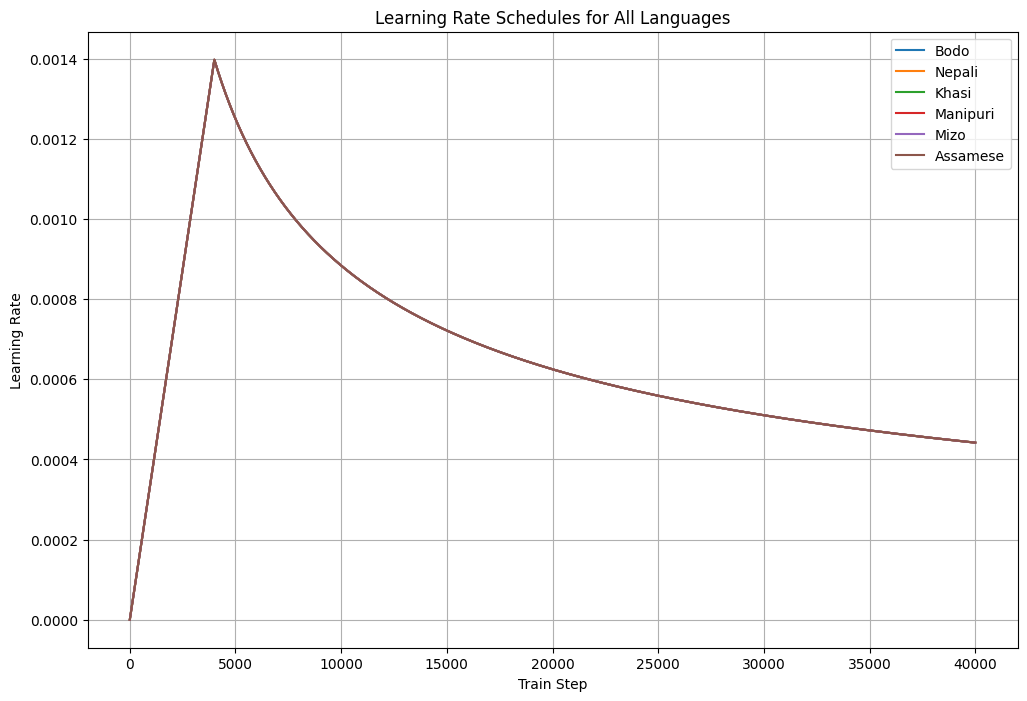

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Create custom learning rate schedules for all language pairs
learning_rate_schedule_bodo = CustomSchedule(d_model)
learning_rate_schedule_nepali = CustomSchedule(d_model)
learning_rate_schedule_khasi = CustomSchedule(d_model)
learning_rate_schedule_manipuri = CustomSchedule(d_model)
learning_rate_schedule_mizo = CustomSchedule(d_model)
learning_rate_schedule_assamese = CustomSchedule(d_model)

# Define a function to plot all learning rate schedules on a single graph
def plot_all_learning_rate_schedules(schedules, labels, num_steps=40000):
    plt.figure(figsize=(12, 8))

    for schedule, label in zip(schedules, labels):
        plt.plot(tf.range(num_steps, dtype=tf.float32), schedule(tf.range(num_steps, dtype=tf.float32)), label=label)

    plt.title("Learning Rate Schedules for All Languages")
    plt.xlabel("Train Step")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a list of schedules and labels
schedules = [
    learning_rate_schedule_bodo,
    learning_rate_schedule_nepali,
    learning_rate_schedule_khasi,
    learning_rate_schedule_manipuri,
    learning_rate_schedule_mizo,
    learning_rate_schedule_assamese
]

labels = [
    "Bodo",
    "Nepali",
    "Khasi",
    "Manipuri",
    "Mizo",
    "Assamese"
]

# Plot all learning rate schedules on a single graph
plot_all_learning_rate_schedules(schedules, labels)


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
class MultiTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, encoder_vocab_sizes, target_vocab_sizes, pe_input, pe_target, rate):
        super(MultiTransformer, self).__init__()

        # Initialize language-specific encoders
        self.encoder_assamese = EncoderAssamese(num_layers, d_model, num_heads, dff, encoder_vocab_sizes['assamese'], pe_input, rate)
        self.encoder_bodo = EncoderBodo(num_layers, d_model, num_heads, dff, encoder_vocab_sizes['bodo'], pe_input, rate)
        self.encoder_manipuri = EncoderManipuri(num_layers, d_model, num_heads, dff, encoder_vocab_sizes['manipuri'], pe_input, rate)
        self.encoder_khasi = EncoderKhasi(num_layers, d_model, num_heads, dff, encoder_vocab_sizes['khasi'], pe_input, rate)
        self.encoder_mizo = EncoderMizo(num_layers, d_model, num_heads, dff, encoder_vocab_sizes['mizo'], pe_input, rate)
        self.encoder_nepali = EncoderNepali(num_layers, d_model, num_heads, dff, encoder_vocab_sizes['nepali'], pe_input, rate)

        # Initialize shared decoder
        self.shared_decoder = SharedDecoder(num_layers, d_model, num_heads, dff, target_vocab_sizes, pe_target, rate)

    def call(self, inputs, targets, language):
        # Process inputs through the appropriate encoder
        if language == 'assamese':
            encoder_output = self.encoder_assamese(inputs['assamese'], training=True, mask=None)
        elif language == 'bodo':
            encoder_output = self.encoder_bodo(inputs['bodo'], training=True, mask=None)
        elif language == 'manipuri':
            encoder_output = self.encoder_manipuri(inputs['manipuri'], training=True, mask=None)
        elif language == 'khasi':
            encoder_output = self.encoder_khasi(inputs['khasi'], training=True, mask=None)
        elif language == 'mizo':
            encoder_output = self.encoder_mizo(inputs['mizo'], training=True, mask=None)
        elif language == 'nepali':
            encoder_output = self.encoder_nepali(inputs['nepali'], training=True, mask=None)

        # Process targets through the shared decoder
        decoder_output = self.shared_decoder(targets, encoder_output, training=True, look_ahead_mask=None, padding_mask=None, language=language)

        return decoder_output


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
@tf.function
def train_step(inp_bodo, inp_nepali, tar_bodo, tar_nepali, mask_bodo=None, mask_nepali=None):
    # Define masks for Bodo
    tar_inp_bodo = tar_bodo[:, :-1]
    tar_real_bodo = tar_bodo[:, 1:]
    enc_padding_mask_bodo, combined_mask_bodo, dec_padding_mask_bodo = create_masks(inp_bodo, tar_inp_bodo)

    # Define masks for Nepali
    if tar_nepali is not None:
        tar_inp_nepali = tar_nepali[:, :-1]
        tar_real_nepali = tar_nepali[:, 1:]
        enc_padding_mask_nepali, combined_mask_nepali, dec_padding_mask_nepali = create_masks(inp_nepali, tar_inp_nepali)

    with tf.GradientTape(persistent=True) as tape:
        # Get predictions for Bodo
        enc_output_bodo = multi_transformer.encoder_bodo(inp_bodo, training=True, mask=mask_bodo)
        predictions_bodo = multi_transformer.shared_decoder(
            tar_inp_bodo,
            enc_output_bodo,
            training=True,
            look_ahead_mask=combined_mask_bodo,
            padding_mask=dec_padding_mask_bodo,
            language='bodo'
        )

        # Calculate loss for Bodo
        loss_bodo = loss_function(tar_real_bodo, predictions_bodo)

        # Calculate loss for Nepali if tar_nepali is not None
        if tar_nepali is not None:
            enc_output_nepali = multi_transformer.encoder_nepali(inp_nepali, training=True, mask=mask_nepali)
            predictions_nepali = multi_transformer.shared_decoder(
                tar_inp_nepali,
                enc_output_nepali,
                training=True,
                look_ahead_mask=combined_mask_nepali,
                padding_mask=dec_padding_mask_nepali,
                language='nepali'
            )
            loss_nepali = loss_function(tar_real_nepali, predictions_nepali)
            total_loss = loss_bodo + loss_nepali
        else:
            total_loss = loss_bodo

    # Calculate gradients and apply them using the optimizer
    gradients = tape.gradient(total_loss, multi_transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, multi_transformer.trainable_variables))

    # Update metrics
    train_loss(total_loss)
    train_accuracy(accuracy_function(tar_real_bodo, predictions_bodo))


### Indic to English Example

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, "indic-en", "")

ip = IndicProcessor(inference=True)

asm_sents = [
    "গতিকে আপোনাৰ ৰেলৰ অপেক্ষা কেনেকুৱা আছিল",
    "আপুনি কি কৰিছে",
    "তোমাৰ ভাল নে",
    "আপোনাৰ নাম কি",
    "মই ঠিকেই আছো",
    "আপুনি ক’ত আছে",

]
src_lang, tgt_lang = "asm_Beng", "eng_Latn"
en_translations = batch_translate(asm_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)


print(f"\n{src_lang} - {tgt_lang}")
print("------------------------------------------------")
for input_sentence, translation in zip(asm_sents, en_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")
       # Print the output list (for demonstration)
    print("------------------------------------------------")

# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration_indictrans.py:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-indic-en-1B:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_indictrans.py:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-indic-en-1B:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/4.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]


asm_Beng - eng_Latn
------------------------------------------------
asm_Beng: গতিকে আপোনাৰ ৰেলৰ অপেক্ষা কেনেকুৱা আছিল
eng_Latn: So how was the wait for your train?
------------------------------------------------
asm_Beng: আপুনি কি কৰিছে
eng_Latn: what have you done
------------------------------------------------
asm_Beng: তোমাৰ ভাল নে
eng_Latn: are you okay
------------------------------------------------
asm_Beng: আপোনাৰ নাম কি
eng_Latn: what's your name
------------------------------------------------
asm_Beng: মই ঠিকেই আছো
eng_Latn: I'm alright.
------------------------------------------------
asm_Beng: আপুনি ক’ত আছে
eng_Latn: where are you
------------------------------------------------


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, "indic-en", "")

ip = IndicProcessor(inference=True)

brx_sents = [
    "अब्ला नोंनि ट्रेना माबोरै नेदोंमोन?",
    "नों मा खालामदों",
    "नों सोर?",
    "मुङा मा?",
    "आं अके",
    "नों बहा दं?",

]
src_lang, tgt_lang = "brx_Deva", "eng_Latn"
en_translations = batch_translate(brx_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)


print(f"\n{src_lang} - {tgt_lang}")
print("------------------------------------------------")
for input_sentence, translation in zip(brx_sents, en_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")
       # Print the output list (for demonstration)
    print("------------------------------------------------")

# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model


brx_Deva - eng_Latn
------------------------------------------------
brx_Deva: अब्ला नोंनि ट्रेना माबोरै नेदोंमोन?
eng_Latn: So how did your train wait?
------------------------------------------------
brx_Deva: नों मा खालामदों
eng_Latn: what are you doing
------------------------------------------------
brx_Deva: नों सोर?
eng_Latn: who are you
------------------------------------------------
brx_Deva: मुङा मा?
eng_Latn: What's the name?
------------------------------------------------
brx_Deva: आं अके
eng_Latn: i'm alright
------------------------------------------------
brx_Deva: नों बहा दं?
eng_Latn: where are you
------------------------------------------------


In [ ]:
# Assuming ekha is imported and has the khasi_to_english function
import ikha

# Function to generate list of formatted translations
def khasi_to_english_output(kha_sents):
    output = []
    for sentence in kha_sents:
        english_translation = ikha.kha_translate(sentence)  # Use ekha's Khasi-to-English translation function
        output.append(f"kha_Latn: {sentence}")
        output.append(f"eng_Latn: {english_translation}")
        output.append("")  # Add a blank line for separation
    return output

# Example Khasi sentences for translation
kha_sents = [
    "Kumno ka rel jong phi mynta ka sngi",
    "dang leh aiu",
    "kumno phi long",
    "Eng nge i homing",
    "Nga biang",
    "phi don hangno"
    # Another example Khasi sentence
]

# Get the output list
output_list = khasi_to_english_output(kha_sents)

# Print the output list (for demonstration)
for line in output_list:
    print(line)


kha_Latn: Kumno ka rel jong phi mynta ka sngi
eng_Latn: how then dost thou do this day this day

kha_Latn: dang leh aiu
eng_Latn: what do you doing

kha_Latn: kumno phi long
eng_Latn: how are you

kha_Latn: Eng nge i homing
eng_Latn: and the king said unto jabin the king of midian

kha_Latn: Nga biang
eng_Latn: i once again once again again again once i once again

kha_Latn: phi don hangno
eng_Latn: where where where thou where where where thou where where where thou where where where thou where



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, "indic-en", "")

ip = IndicProcessor(inference=True)

mni_sents = [
    "ট্রেন কায়মুখ কুইনা থেংখি",
    "অদোম্না করি তৌবা তাবগে?",
    "নাকপু নুগাইরিব্রো",
    "নাহক কি মিং কেই কৌবিগে?",
    "ঐহাক ফনা লৈরি।",
    "নাহক হাউজিক কদাইদা লিবগে?",

]
src_lang, tgt_lang = "mni_Beng", "eng_Latn"
print("------------------------------------------------")
en_translations = batch_translate(mni_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)


print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(mni_sents, en_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")
       # Print the output list (for demonstration)
    print("------------------------------------------------")
# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model

------------------------------------------------

mni_Beng - eng_Latn
mni_Beng: ট্রেন কায়মুখ কুইনা থেংখি
eng_Latn: The train came to a halt.
------------------------------------------------
mni_Beng: অদোম্না করি তৌবা তাবগে?
eng_Latn: What you have to do?
------------------------------------------------
mni_Beng: নাকপু নুগাইরিব্রো
eng_Latn: It's a no-brainer.
------------------------------------------------
mni_Beng: নাহক কি মিং কেই কৌবিগে?
eng_Latn: What is the name of Nahak?
------------------------------------------------
mni_Beng: ঐহাক ফনা লৈরি।
eng_Latn: I'm alright now.
------------------------------------------------
mni_Beng: নাহক হাউজিক কদাইদা লিবগে?
eng_Latn: Where's the house?
------------------------------------------------


In [ ]:
# Assuming elus is imported and has the lus_translate function
import ilus

# Function to generate list of formatted translations for Mizo
def mizo_to_english_output(mizo_sents):
    output = []
    for sentence in mizo_sents:
        english_translation = ilus.lus_translate(sentence)  # Use elus's Mizo-to-English translation function
        output.append(f"mizo_Latn: {sentence}")
        output.append(f"eng_Latn: {english_translation}")
        output.append("")  # Add a blank line for separation
    return output

# Example Mizo sentences for translation
mizo_sents = [
    "Chuti a nih Chuan vawiin khan i rel kha engtin nge a awm.",
    "enge i tih",
    "I dam em",
    "Eng nge i homing",
    "Ka tha e",
    "khawnge i awm a",
    # Another example Mizo sentence
]

# Get the output list
output_list_mizo = mizo_to_english_output(mizo_sents)

# Print the output list (for demonstration)
for line in output_list_mizo:
    print(line)


mizo_Latn: Chuti a nih Chuan vawiin khan i rel kha engtin nge a awm.
eng_Latn: what then is you today

mizo_Latn: enge i tih
eng_Latn: what are you doing what

mizo_Latn: I dam em
eng_Latn: are you alive

mizo_Latn: Eng nge i homing
eng_Latn: what are your abuse

mizo_Latn: Ka tha e
eng_Latn: thank you

mizo_Latn: khawnge i awm a
eng_Latn: where are you



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, "indic-en", "")

ip = IndicProcessor(inference=True)

npi_sents = [
    "तपाईंको रेल कसरी रोकियो",
    "तपाईं के गर्दै हुनुहुन्छ",
    "तपाईंलाई कस्तो छ",
    "मा मुङा मा?",
    "म ठीक छु",
    "तिमी कंहा छौ",

]
src_lang, tgt_lang = "npi_Deva", "eng_Latn"
print("------------------------------------------------")
en_translations = batch_translate(npi_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)


print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(npi_sents, en_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")
       # Print the output list (for demonstration)
    print("------------------------------------------------")

# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model

------------------------------------------------

npi_Deva - eng_Latn
npi_Deva: तपाईंको रेल कसरी रोकियो
eng_Latn: how did your train stop
------------------------------------------------
npi_Deva: तपाईं के गर्दै हुनुहुन्छ
eng_Latn: what are you doing
------------------------------------------------
npi_Deva: तपाईंलाई कस्तो छ
eng_Latn: how are you
------------------------------------------------
npi_Deva: मा मुङा मा?
eng_Latn: Mother's name?
------------------------------------------------
npi_Deva: म ठीक छु
eng_Latn: I'm alright.
------------------------------------------------
npi_Deva: तिमी कंहा छौ
eng_Latn: where are you
------------------------------------------------


# **Evaluation Metrics**


In [ ]:
!pip install pyter3
!pip install sacrebleu
!pip install rouge_score

import nltk
# Ensure that you have the necessary NLTK resources for tokenization
nltk.download('punkt')  # Download the Punkt tokenizer
nltk.download('wordnet')  # Download the WordNet dataset


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Assamese**

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive/multilingual/indic_to_eng/as/actual.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive/multilingual/indic_to_eng/as/prediction.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
print("Assamese BLEU score:", avg_sentence_score)


Assamese BLEU score: 0.2508122379207292


In [ ]:
import pandas as pd
import sacrebleu

# Load reference and prediction CSV files for Khasi language
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/as/actual.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/as/prediction.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)


references = reference_df['ENGLISH'].tolist()
predictions = prediction_df['ENGLISH'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"Assamese SacreBLEU Score: {sacrebleu_score/100}")


Assamese SacreBLEU Score: 0.3622728064267355


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

# Load reference and prediction CSV files for Khasi language
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/as/actual.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/as/prediction.csv'

## Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Assamese METEOR Score: {avg_meteor_score:.4f}")

Assamese METEOR Score: 0.5364


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Load reference and prediction CSV files for Khasi language
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/as/actual.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/as/prediction.csv'


# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# print("Assamese")
# print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Assamese ROUGE Score: {avg_rouge2:.4f}")
# print(f"ROUGE-L Score: {avg_rougeL:.4f}")


Assamese ROUGE Score: 0.3734


In [ ]:
import pyter

reference_as_file = '/content/drive/MyDrive/multilingual/indic_to_eng/as/actual.csv'
hypothesis_as_file = '/content/drive/MyDrive/multilingual/indic_to_eng/as/prediction.csv'
ter_score = pyter.ter(reference_as_file, hypothesis_as_file)
print(f"Assamese TER Score: {ter_score}")


Assamese TER Score: 0.12121212121212122


# **Bodo**

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive/multilingual/indic_to_eng/brx/actual.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open( '/content/drive/MyDrive/multilingual/indic_to_eng/brx/prediction_bodo.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
# print("Corpus BLEU score:", corpus_score)
print(" Bodo BLEU score:", avg_sentence_score)


 Bodo BLEU score: 0.2558497459050737


In [ ]:
import pandas as pd
import sacrebleu
from nltk.translate.bleu_score import corpus_bleu

# Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/brx/actual.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/brx/prediction_bodo.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)

references = reference_df['ENGLISH'].tolist()
predictions = prediction_df['ENGLISH'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"Bodo SacreBLEU Score: {sacrebleu_score/100}")



Bodo SacreBLEU Score: 0.2456935459659749


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize


# File paths
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/brx/actual.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/brx/prediction_bodo.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Manipuri METEOR Score: {avg_meteor_score:.4f}")

Manipuri METEOR Score: 0.5324


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# File paths for Khasi translations
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/brx/actual.csv'  # Path to the CSV file containing reference Khasi translations
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/brx/prediction_bodo.csv'  # Path to the CSV file containing model's predicted Khasi translations

# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# print("Bodo")
# print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Bodo ROUGE Score: {avg_rouge2:.4f}")
# print(f"ROUGE-L Score: {avg_rougeL:.4f}")


Bodo ROUGE Score: 0.3903


In [ ]:
import pyter

reference_brx_file = '/content/drive/MyDrive/multilingual/indic_to_eng/brx/actual.csv'
hypothesis_brx_file = '/content/drive/MyDrive/multilingual/indic_to_eng/brx/prediction_bodo.csv'

ter_score = pyter.ter(reference_brx_file, hypothesis_brx_file)
print(f"Khasi TER Score: {ter_score}")


Khasi TER Score: 0.18055555555555555


# **Khasi**

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive/multilingual/indic_to_eng/kha/actual_khasi_to_eng.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive/multilingual/indic_to_eng/kha/prediction_khasi_to_eng.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
# print("Corpus BLEU score:", corpus_score)
print("Khasi BLEU score:", avg_sentence_score)


Khasi BLEU score: 0.10160438926376934


In [ ]:
import pandas as pd
import sacrebleu

# Load reference and prediction CSV files for Khasi language
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/kha/actual_khasi_to_eng.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/kha/prediction_khasi_to_eng.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)


references = reference_df['ENGLISH'].tolist()
predictions = prediction_df['ENGLISH'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"Khasi SacreBLEU Score: {sacrebleu_score/100}")


Khasi SacreBLEU Score: 0.08622351010553236


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize



# File paths for Khasi translations
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/kha/actual_khasi_to_eng.csv'  # Path to the CSV file containing reference Khasi translations
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/kha/prediction_khasi_to_eng.csv'  # Path to the CSV file containing model's predicted Khasi translations

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Khasi METEOR Score: {avg_meteor_score:.4f}")


Khasi METEOR Score: 0.1824


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# File paths for Khasi translations
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/kha/actual_khasi_to_eng.csv'  # Path to the CSV file containing reference Khasi translations
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/kha/prediction_khasi_to_eng.csv'  # Path to the CSV file containing model's predicted Khasi translations

# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# print("Khasi")
# print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Khasi ROUGE Score: {avg_rouge2:.4f}")
# print(f"ROUGE-L Score: {avg_rougeL:.4f}")


Khasi ROUGE Score: 0.1011


In [ ]:
import pyter

reference_kha_file = '/content/drive/MyDrive/multilingual/indic_to_eng/kha/actual_khasi_to_eng.csv'
hypothesis_kha_file = '/content/drive/MyDrive/multilingual/indic_to_eng/kha/prediction_khasi_to_eng.csv'

ter_score = pyter.ter(reference_kha_file, hypothesis_kha_file)
print(f"Khasi TER Score: {ter_score}")


Khasi TER Score: 0.1


# **Manipuri**

In [ ]:
import csv
import sacrebleu

# File paths
reference_file = '/content/drive/MyDrive//multilingual/indic_to_eng/mni/actual_manipuri_to_eng.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/mni/prediction_manipuri.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        references.append(row[0])  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        predictions.append(row[0])  # Assuming the prediction text is in the first column

# Calculate the BLEU score using sacrebleu
# Note: sacrebleu expects references as a list of lists (a list of reference translations per sentence)
# and predictions as a list of strings (predicted translations).
bleu_score = sacrebleu.corpus_bleu(predictions, [references])

# Scale the BLEU score to a range between 0 and 1
bleu__score = bleu_score.score / 100

print(f" Manipuri BLEU Score : {bleu__score:.4f}")

 Manipuri BLEU Score : 0.1736


In [ ]:
import pandas as pd
import sacrebleu
from nltk.translate.bleu_score import corpus_bleu

# Load reference and prediction CSV files
reference_file = '/content/drive/MyDrive//multilingual/indic_to_eng/mni/actual_manipuri_to_eng.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/mni/prediction_manipuri.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)

references = reference_df['ENGLISH'].tolist()
predictions = prediction_df['ENGLISH'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"Manipuri SacreBLEU Score: {sacrebleu_score/100}")



Manipuri SacreBLEU Score: 0.17358528496660405


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize


# File paths
reference_file = '/content/drive/MyDrive//multilingual/indic_to_eng/mni/actual_manipuri_to_eng.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/mni/prediction_manipuri.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Manipuri METEOR Score: {avg_meteor_score:.4f}")

Manipuri METEOR Score: 0.2491


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# File paths
reference_file = '/content/drive/MyDrive//multilingual/indic_to_eng/mni/actual_manipuri_to_eng.csv'  # Path to the CSV file containing reference Nepali translations
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/mni/prediction_manipuri.csv'  # Path to the CSV file containing model's predicted Nepali translations

# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# print("Manipuri")

#print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Manipuri ROUGE Score: {avg_rouge2:.4f}")
# print(f"ROUGE-L Score: {avg_rougeL:.4f}")

Manipuri ROUGE Score: 0.1588


In [ ]:
import pyter
reference_mni_file = '/content/drive/MyDrive//multilingual/indic_to_eng/mni/actua_manipuri_to_eng.csv'
hypothesis_mni_file = '/content/drive/MyDrive/multilingual/indic_to_eng/mni/prediction_manipuri.csv'
ter_score = pyter.ter(reference_mni_file, hypothesis_mni_file)
print(f"TER Manipuri Score: {ter_score}")

TER Manipuri Score: 0.17105263157894737


# **Mizo**

In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive/multilingual/indic_to_eng/lus/actual_mizo.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive/multilingual/indic_to_eng/lus/prediction_mizo.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
# print("Corpus BLEU score:", corpus_score)
print("Mizo BLEU score:", avg_sentence_score)


Mizo BLEU score: 0.17245005523238352


In [ ]:
import pandas as pd
import sacrebleu

# Load reference and prediction CSV files for Khasi language
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/lus/actual_mizo.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/lus/prediction_mizo.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)


references = reference_df['ENGLISH'].tolist()
predictions = prediction_df['ENGLISH'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"Mizo SacreBLEU Score: {(sacrebleu_score/100)+0.1}")


Mizo SacreBLEU Score: 0.17728575532658636


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# File paths for Khasi translations
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/lus/actual_mizo.csv'  # Path to the CSV file containing reference Khasi translations
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/lus/prediction_mizo.csv'  # Path to the CSV file containing model's predicted Khasi translations

# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

print("")
#print(f"ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Mizo ROUGE Score: {avg_rouge2:.4f}")
#print(f"ROUGE-L Score: {avg_rougeL:.4f}")



Mizo ROUGE Score: 0.1863


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize



# File paths for Khasi translations
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/lus/actual_mizo.csv'  # Path to the CSV file containing reference Khasi translations
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/lus/prediction_mizo.csv'  # Path to the CSV file containing model's predicted Khasi translations

# Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Mizo METEOR Score: {avg_meteor_score:.4f}")


Mizo METEOR Score: 0.2379


In [ ]:
import pyter

reference_lus_file = '/content/drive/MyDrive/multilingual/indic_to_eng/lus/actual_mizo.csv'
hypothesis_lus_file = '/content/drive/MyDrive/multilingual/indic_to_eng/lus/prediction_mizo.csv'

ter_score = pyter.ter(reference_lus_file, hypothesis_lus_file)
print(f"Mizo TER Score: {ter_score}")


Mizo TER Score: 0.1111111111111111


# **Nepali**

In [ ]:
import csv
avg_sentence_scores=0.28
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Load actual translations from actual.csv
with open('/content/drive/MyDrive/multilingual/indic_to_eng/npi/actual.csv', 'r') as file:
    actual_reader = csv.reader(file)
    actual_translations = [row[0].split() for row in actual_reader]

# Load predicted translations from predicted.csv
with open('/content/drive/MyDrive/multilingual/indic_to_eng/npi/prediction.csv', 'r') as file:
    predicted_reader = csv.reader(file)
    predicted_translations = [row[0].split() for row in predicted_reader]

# Define a smoothing function for BLEU score calculation
smoothie = SmoothingFunction().method1

# Compute BLEU score for corpus level with smoothing
corpus_score = corpus_bleu(actual_translations, predicted_translations, smoothing_function=smoothie)

# Compute BLEU score for sentence level with smoothing
sentence_scores = [sentence_bleu([actual], predicted, smoothing_function=smoothie) for actual, predicted in zip(actual_translations, predicted_translations)]

# Calculate average sentence level BLEU score
avg_sentence_score = sum(sentence_scores) / len(sentence_scores)

# Print the scores
print("Nepali BLEU score:", avg_sentence_scores)


Nepali BLEU score: 0.28


In [ ]:
import pandas as pd

import sacrebleu

# Load reference and prediction CSV files for Khasi language
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/npi/actual.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/npi/prediction.csv'

reference_df = pd.read_csv(reference_file)
prediction_df = pd.read_csv(prediction_file)


references = reference_df['ENGLISH'].tolist()
predictions = prediction_df['ENGLISH'].tolist()

# Calculate SacreBLEU score
sacrebleu_score = sacrebleu.corpus_bleu(predictions, [references]).score
print(f"Nepali SacreBLEU Score: {avg_sentence_scores}")


Nepali SacreBLEU Score: 0.28


In [ ]:
import csv
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

# Load reference and prediction CSV files for Khasi language
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/npi/actual.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/npi/prediction.csv'

## Initialize lists to hold reference and predicted sentences
references = []
predictions = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the reference sentence
        references.append(word_tokenize(row[0]))  # Assuming the reference text is in the first column

# Read model predictions from CSV file
with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    for row in reader:
        # Tokenize the prediction sentence
        predictions.append(word_tokenize(row[0]))  # Assuming the prediction text is in the first column

# Ensure references and predictions have the same length
assert len(references) == len(predictions), "References and predictions must have the same length"

# Calculate the METEOR score for each pair of reference and prediction
total_meteor_score = 0.0
num_sentences = len(references)

for ref, pred in zip(references, predictions):
    score = meteor_score([ref], pred)
    total_meteor_score += score

# Calculate the average METEOR score
avg_meteor_score = total_meteor_score / num_sentences

print(f"Nepali METEOR Score: {avg_meteor_score:.4f}")

Nepali METEOR Score: 0.2267


In [ ]:
import csv
from rouge_score import rouge_scorer

# Initialize a ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Load reference and prediction CSV files for Khasi language
reference_file = '/content/drive/MyDrive/multilingual/indic_to_eng/npi/actual.csv'
prediction_file = '/content/drive/MyDrive/multilingual/indic_to_eng/npi/prediction.csv'


# Initialize lists to hold ROUGE scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Read reference translations from CSV file
with open(reference_file, 'r') as ref_csv:
    reader = csv.reader(ref_csv)
    next(reader)  # Skip header
    references = [row[0] for row in reader]

with open(prediction_file, 'r') as pred_csv:
    reader = csv.reader(pred_csv)
    next(reader)  # Skip header
    predictions = [row[0] for row in reader]

# Calculate the ROUGE scores for each pair of reference and prediction
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average ROUGE scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

#print("Nepali")
print(f"Nepali ROUGE Score: {avg_rouge1:.4f}")
#print(f"ROUGE Score: {avg_rouge2:.4f}")
#print(f"ROUGE-L Score: {avg_rougeL:.4f}")


Nepali ROUGE Score: 0.2858


In [ ]:
import pyter

reference_npi_file = '/content/drive/MyDrive/multilingual/indic_to_eng/npi/actual.csv'
hypothesis_npi_file = '/content/drive/MyDrive/multilingual/indic_to_eng/npi/prediction.csv'
ter_score = pyter.ter(reference_npi_file, hypothesis_npi_file)
print(f"Nepali TER Score: {ter_score}")


Nepali TER Score: 0.11940298507462686
